### The overall workflow for signal analysis in the TVB simulated LFPs data 

This is the main part of my analysis in **"Brain lateralization in AD"** project.

The workflow of the analysis can be divided by several parts:

1. read the data
2. calculate freqency, amplitude, delay, and phase-amplitude coupling metrics.
3. calculate the lateralization indexes
4. calculate the slope information (similar to lateralization, but forcus on the rate of changes between left and right)
5. calculate the stats between four groups
6. visualization the results

In [4]:
import sys
sys.path.append('/home/yat-lok/workspace/tvbtools/')
# sys.path.append('/mnt/w/github/tvbtools/')
from tools.signaltools import SignalToolkit
from tools.statools import stats_calculator
from tools.pathconverter import prefix_path
pth = prefix_path()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
my_layout = widgets.Layout()
plt.style.use('ggplot')
import os

In [6]:
path = '/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/gc1sec_res.xlsx'
coData = pd.read_excel(path)
tb = stats_calculator(coData)
tb.to_excel("/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/gc1sec_with_gamma_theta.xlsx")

In [ ]:
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMp-R','mTEMp-L','mTEMp-R']
fs = 81920.0
samplinginterval = 1/fs
t = np.arange(0, 1, samplinginterval)
grps = ['SNC','NC','MCI','AD']
col = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
# path = '/mnt/w/Gc_Go.xlsx'
path = '/home/yat-lok/workspace/data4project/lateralization/tvb_parameters.xlsx'
coData = pd.read_excel(path)

def read_data(grp, caseid, amp='p2v'):
    gm = np.round(coData.loc[coData['caseid'] == caseid, 'Gc'].item(), 3)
    filename = '/home/yat-lok/workspace/data4project/lateralization/LFP_critical/'+str(grp)+'/'+str(caseid)+'_'+str(gm)+'.csv'
    # filename = '/mnt/w/gc3mins/'+grp+'/'+caseid+'.h5'
    subject = SignalToolkit(filename, 81920.)
    df = subject.data_reader()

    cutoff_low = 2.
    cutoff_high = 10.
    spikesparas = {'prominence': 1.0}
    valleysparas= {'prominence': 0.2, 'width':2000, 'height': -0.5}
    spikesparas_af= {'prominence': 0.3, 'width':2000, 'height': 0.}
    valleysparas_af = {'prominence': 0.2, 'width':2000, 'height': -0.5}

    pcgl=subject.signal_package(data=df, channel_num = 4, label='pcg_left', low=cutoff_low, high=cutoff_high, spikesparas=spikesparas, valleysparas=valleysparas, spikesparas_af=spikesparas_af, valleysparas_af = valleysparas, truncate=0)
    pcgr=subject.signal_package(data=df, channel_num = 5, label='pcg_right', low=cutoff_low, high=cutoff_high, spikesparas=spikesparas, valleysparas=valleysparas, spikesparas_af=spikesparas_af, valleysparas_af=valleysparas_af, truncate=0)

    # # visualization
    # fig = plt.figure(figsize=(15,5))
    # axes = fig.add_subplot(111)
    # axes.set_title(f"{grp}_{caseid}")
    # subject.signal_af(**pcgl, axes=axes)
    # subject.signal_af(**pcgr, axes=axes)
    # plt.legend()
    # plt.savefig(f"/mnt/c/Users/Wayne/tvb/gc1sec_res/{grp}/{caseid}.png", dpi = 300)

    # freq
    pcgl_freq_gamma = subject.freq_count(pcgl["spikeslist"])
    pcgr_freq_gamma = subject.freq_count(pcgr["spikeslist"])
    pcgl_freq_theta = subject.freq_count(pcgl["spikeslist_af"])
    pcgr_freq_theta = subject.freq_count(pcgr["spikeslist_af"])

    # amp
    if amp in ['p2v']:
        pcgl_amp_gamma = subject.amp_count(**pcgl, mode="p2v")
        pcgr_amp_gamma = subject.amp_count(**pcgr, mode="p2v")
        pcgl_amp_theta = subject.amp_count(data=pcgl["after_filtered"], spikeslist=pcgl["spikeslist_af"], valleyslist=pcgl["valleyslist_af"], mode="p2v")
        pcgr_amp_theta = subject.amp_count(data=pcgr["after_filtered"], spikeslist=pcgr["spikeslist_af"], valleyslist=pcgr["valleyslist_af"], mode="p2v")
    elif amp in ['ap']:
        # another version of amp
        pcgl_amp_gamma, pcgl_amp_theta = subject.amp_count(**pcgl, mode="ap")
        pcgr_amp_gamma, pcgr_amp_theta = subject.amp_count(**pcgr, mode="ap")


    # delay
    pcg_delay = subject.phase_delay(pcgl["after_filtered"], pcgr["after_filtered"], pcgl["spikeslist_af"], pcgl["valleyslist_af"], pcgr["spikeslist_af"], pcgr["valleyslist_af"], mode = "SI")

    lowl = SignalToolkit.sos_filter(pcgl["data"], [2,6], fs=fs)
    lowr = SignalToolkit.sos_filter(pcgr["data"], [2,6], fs=fs)
    highl = SignalToolkit.sos_filter(pcgl["data"], [20,45], fs=fs)
    highr = SignalToolkit.sos_filter(pcgr["data"], [20,45], fs=fs)
    pcgl_plv = subject.phase_locking(lowl, highl)
    pcgr_plv = subject.phase_locking(lowr, highr)

    pcgl_pac = SignalToolkit.PAC(pcgl["data"], [2,6], [20,45], fs=fs)
    pcgr_pac = SignalToolkit.PAC(pcgr["data"], [2,6], [20,45], fs=fs)

    ## comodulogram
    #fig = plt.figure(figsize=(15,7), dpi=300)
    #axes1 = fig.add_subplot(121)
    como_left = SignalToolkit.PAC_comodulogram(pcgl["data"], [2,20,4], [20,100,5], fs=fs, visual=False)
    #axes2 = fig.add_subplot(122)
    como_right = SignalToolkit.PAC_comodulogram(pcgr["data"], [2,20,4], [20,100,5], fs=fs, visual=False)
    #plt.savefig(f"/mnt/c/Users/Wayne/tvb/gc1sec_res/como/{grp}/{caseid}.png")
    # pcg_pac = np.abs(pcgr_pac - pcgl_pac)


    res_dict = {"group":grp, 
    "caseid":caseid, 
    "pcgl_freq_gamma":pcgl_freq_gamma,
    "pcgr_freq_gamma":pcgr_freq_gamma,
    "pcgl_freq_theta":pcgl_freq_theta,
    "pcgr_freq_theta":pcgr_freq_theta,
    "pcgl_amp_gamma":pcgl_amp_gamma,
    "pcgr_amp_gamma":pcgr_amp_gamma,
    "pcgl_amp_theta":pcgl_amp_theta,
    "pcgr_amp_theta":pcgr_amp_theta,
    "pcgl_pac":pcgl_pac,
    "pcgr_pac":pcgr_pac,
    "pcgl_plv": pcgl_plv,
    "pcgr_plv":pcgr_plv,
    "pcg_delay":pcg_delay}
    #"pcg_pac": pcg_pac}
    como_dict = {"left": como_left.to_numpy(), "right":como_right.to_numpy()}



    # res_dict = {"group":grp, 
    # "caseid":caseid, 
    # "pcg_gamma_freq":pcgr_freq_gamma - pcgl_freq_gamma,
    # "pcg_theta_freq":pcgr_freq_theta - pcgl_freq_theta,
    # "pcg_gamma_amp":pcgr_amp_gamma - pcgl_amp_gamma,
    # "pcg_theta_amp":pcgr_amp_theta - pcgl_amp_theta,
    # "pcg_delay":pcg_delay}

    #return res_dict
    return res_dict, como_dict

    # fig = plt.figure(figsize=(15,5))
    # axes = fig.add_subplot(111)
    # for i in range(16):
    #     _, power = subject.psd(df[:,i], sampling_interval = 1/fs, visual=True, xlim=100., axes=axes, label=f"{node_names[i]}")
    #     if i == 4:
    #         highest_pcg_left = np.argmax(power)
    #     if i == 5:
    #         highest_pcg_right = np.argmax(power)
    # axes.set_title(f"{grp}_{caseid}")
    # plt.savefig(f"/mnt/c/Users/wayne/tvb/psdres/{grp}_{caseid}.png", dpi=300)
    # return highest_pcg_left, highest_pcg_right

In [ ]:
# # grab overall results
dfa = pd.DataFrame()
for grp, caseid in zip(coData.groups, coData.caseid):
    res_dict, _ = read_data(grp, caseid)
    dfa = pd.concat([dfa, pd.DataFrame.from_dict([res_dict])], ignore_index=True)

dfa.to_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/gc1sec_res.xlsx')

In [ ]:
# import seaborn as sns
# # # grab overall results
# dfl = np.zeros((5, 16, len(coData.groups)))
# dfr = np.zeros((5, 16, len(coData.groups)))
# co=0
# for grp, caseid in zip(coData.groups, coData.caseid):
#     _, como = read_data(grp, caseid)
#     dfl[:,:,co] = como["left"]
#     dfr[:,:,co] = como["right"]
#     co+=1
# snc_mean = np.mean(dfr[:,:,:10], axis=2)
# nc_mean = np.mean(dfr[:,:,10:26], axis=2)
# mci_mean = np.mean(dfr[:,:,26:61], axis=2)
# ad_mean = np.mean(dfr[:,:,61:74], axis=2)

# fig = plt.figure()
# axes = fig.add_subplot(221)
# sns.heatmap(snc_mean, ax=axes)
# axes2 = fig.add_subplot(222)
# sns.heatmap(nc_mean, ax=axes2)
# axes3 = fig.add_subplot(223)
# sns.heatmap(mci_mean, ax=axes3)
# axes4 = fig.add_subplot(224)
# sns.heatmap(ad_mean, ax=axes4)
# plt.show()

In [ ]:
# grab lateralization results

#%matplotlib widget
# print(coData)
# read_data('MCI', "2050A")
df = pd.DataFrame()
laname = ['LI_freq_gamma', 'LI_freq_theta', 'LI_amp_gamma', 'LI_amp_theta', "LI_pac", "LI_plv"]
la_dict = {}
for grp, caseid in zip(coData.groups, coData.caseid):
    res_dict,_ = read_data(grp, caseid)
    _pre_la = [res_dict.get(n) for n in res_dict.keys()][2:]
    la_dict['group'] = grp
    la_dict['caseid'] = caseid
    for ind, n in enumerate(range(0, int(len(_pre_la)-1), 2)):
        _la = SignalToolkit.lateral(_pre_la[n], _pre_la[n+1])
        la_dict[laname[ind]] = _la
        _df = pd.DataFrame.from_dict([la_dict])
    df = pd.concat([df, _df], ignore_index=True)


df.to_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/lateralization.xlsx')


## calculating slope information

In [ ]:
# slope information
import sys
sys.path.append("/home/yat-lok/workspace/tvbtools")
from tools.statools import stats_calculator
import pandas as pd
#%matplotlib widget
# print(coData)
# read_data('MCI', "2050A")
df_slope = pd.DataFrame()
slopename = ['slope_freq_gamma', 'slope_freq_theta', 'slope_amp_gamma', 'slope_amp_theta', "slope_pac", "slope_plv"]
slope_dict = {}

dbf = pd.read_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/gc1sec_res.xlsx')
df_norm = dbf.copy()
def normal_minmax(datatable, column):
    datatable[column] = (datatable[column] - datatable[column].min())/(datatable[column].max() - datatable[column].min())
    return datatable
for i in range(2, len(df_norm.columns)):
    normal_minmax(df_norm, df_norm.columns[i])

_pre_slope = df_norm.iloc[:,2:]
for n in range(0, len(_pre_slope.columns)-1, 2):
    _slope = _pre_slope[_pre_slope.columns[n+1]] - _pre_slope[_pre_slope.columns[n]]
    df_slope = pd.concat([df_slope, _slope], axis=1, ignore_index=True)
df_slope = pd.concat([dbf["group"], dbf["caseid"], df_slope], axis=1, ignore_index=True)
df_slope.columns = ["group", "caseid", *slopename]
slope_tab = stats_calculator(df_slope, mode="P", n=3)
slope_tab.to_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/slope_stats.xlsx')

## quick visualization functions to inspect data 

In [ ]:
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]

import seaborn as sns
def psvplot(x,y, df, colors=None, axes=None):
    sns.violinplot(x=x, y=y, data=df, palette=colors, inner = None, width=0.7, bw=0.2, ax=axes)
    sns.stripplot( data=df, x=x, y=y, color='black', label="right", ax = axes)
    sns.pointplot(x=x, y=y, data=df, estimator=np.mean, color = 'red', ax=axes)

In [ ]:
a=1
fig = plt.figure(figsize=(15,20))
for ind, n in enumerate(range(2, len(dfa.columns))):

    axes = fig.add_subplot(4,4,a+ind)
    psvplot('group',dfa.columns[n], df=dfa, colors=colors, axes=axes)

fig = plt.figure(figsize=(10,7), dpi=300)
for ind, n in enumerate(range(len(laname))):
    axes = fig.add_subplot(2,3,a+ind)
    psvplot('group',laname[n], df, colors=colors, axes=axes)


## calculating 

In [ ]:
import sys
sys.path.append("/home/yat-lok/workspace/tvbtools")
from tools.statools import stats_calculator
import pandas as pd
daf = pd.read_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/lateralization.xlsx')
dbf = pd.read_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/gc1sec_res.xlsx')
dcf = stats_calculator(daf, mode="P", n=3)
ddf = stats_calculator(dbf, mode="P", n=3)

# dcf.to_excel('/mnt/c/Users/Wayne/tvb/gc1sec_res/lateral_stats.xlsx')
# ddf.to_excel('/mnt/c/Users/Wayne/tvb/gc1sec_res/gc1sec_stats.xlsx')

In [ ]:
import sys
sys.path.append("/home/yat-lok/workspace/tvbtools")
from tools.signaltools import SignalToolkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
plt.style.use('ggplot')
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R']


def essay_res1(caseid, grp, key, fig):
    path = '/home/yat-lok/workspace/data4project/lateralization/tvb_parameters.xlsx'
    coData = pd.read_excel(path)
    gm = np.round(coData.loc[coData['caseid'] == caseid, 'Gc'].item(), 3)
    filename = '/home/yat-lok/workspace/data4project/lateralization/LFP_critical/'+str(grp)+'/'+str(caseid)+'_'+str(gm)+'.csv'
    # filename = '/mnt/w/gc3mins/'+grp+'/'+caseid+'.h5'
    df = pd.read_csv(filename)
    
    axes = fig.add_subplot(key)
    axes.set_title(f"{grp}_{caseid}")
    for i in range(16):
        Wn = [2,10]
        fNQ = 81920/2
        n=2048
        b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
        Vlo = signal.filtfilt(b, 1, df.loc[:,node_names[i]]);   # ... and apply it to the data.
        # b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
        # Vhi = signal.filtfilt(b, 1, df.loc[:,node_names[i]]);   # ... and apply it to the data.
        Vlo = SignalToolkit.hamming_filter(data = df.loc[:,node_names[i]], n=4096)
        Vhi = SignalToolkit.hamming_filter(data=df.loc[:,node_names[i]], Wn = [10, 60], n=4096)
        # phi = signal.angle(signal.hilbert(Vlo))  # Compute phase of low-freq signal
        # amp = abs(signal.hilbert(Vhi))       # Compute amplitude of high-freq signal
        if node_names[i] in ['pCNG-L', 'pCNG-R']:
            axes.plot(np.arange(0,1,1/81920), Vlo, label=f"theta_{node_names[i]}")
            axes.plot(np.arange(0,1,1/81920), Vhi, label=f"gamma_{node_names[i]}")
            axes.plot(np.arange(0,1,1/81920), df.loc[:,node_names[i]], label=node_names[i], alpha=0.5)
        # else:
        #     axes.plot(np.arange(0,1,1/81920),df.loc[:,node_names[i]])
    plt.legend()


caseids = ["4849A", "0318A", "7827A", "1477A"]
grps= ['SNC','NC','MCI','AD']
keynum = [221,222,223,224]

fig = plt.figure(figsize=(15,7), dpi=300)
for casid, grp, key in zip(caseids, grps, keynum):
    essay_res1(casid, grp, key, fig)


In [ ]:
from scipy.stats import ranksums
rng = np.random.default_rng()
sample1 = rng.uniform(-1, 1, 200)
sample2 = rng.uniform(-0.5, 1.5, 300) # a shifted distribution
_, pvalue = ranksums(sample1, sample2)
print(pvalue)

In [ ]:
import numpy as np
import itertools
import pandas as pd
import sys
sys.path.append('/home/yat-lok/workspace/tvbtools/')
# sys.path.append('/mnt/w/github/tvbtools/')
from tools.statools import null_dist_max
randict = {"A":np.random.randint(200, size=50), "B":np.random.randint(200, size=45), "C":np.random.randint(100,size=49), "D":np.random.randint(100,size=41)}
df = null_dist_max(randict, visual=True)
print(df)


In [ ]:
import sys
sys.path.append('/home/yat-lok/workspace/tvbtools/')
from tools.statools import stats_calculator
import pandas as pd
ddf = pd.read_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/gc1sec_res.xlsx')
daf = stats_calculator(ddf, mode="max")
print(daf)

### bootstrap interval for slope distribution

/home/yat-lok/.conda/envs/tvbenv/lib/python3.8/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


aCNG SNC (-0.07494430482705178, 0.044637563639541765)
aCNG NC (-0.019395401855476287, 0.048260140631046604)
aCNG MCI (-0.02513974920745034, 0.03193147805246879)
aCNG AD (-0.008238524315132046, 0.07752110569433782)
mCNG SNC (0.00682739605174182, 0.12173371179656056)
mCNG NC (0.031065052389248116, 0.10415185769254283)
mCNG MCI (0.06292796920811801, 0.10701185733787566)
mCNG AD (0.03069872048611729, 0.09597883548699875)
pCNG SNC (-0.40111605345925444, -0.1806388410139794)
pCNG NC (-0.3466824354206845, -0.16778183216202522)
pCNG MCI (-0.3691229712257939, -0.21910338415245356)
pCNG AD (-0.45910263222716197, -0.2771672753317945)
HIP SNC (-0.21778222341654882, -0.005890070034882933)
HIP NC (-0.2435535319251039, -0.06731085578344602)
HIP MCI (-0.12070738817060207, -0.014497541331847875)
HIP AD (-0.09648293277998889, 0.0626521520676376)
PHG SNC (-0.09294870639727255, 0.12060794302690911)
PHG NC (-0.17510446597192805, 0.03282070438730755)
PHG MCI (-0.01718601603429892, 0.1093119535225367)
PHG AD

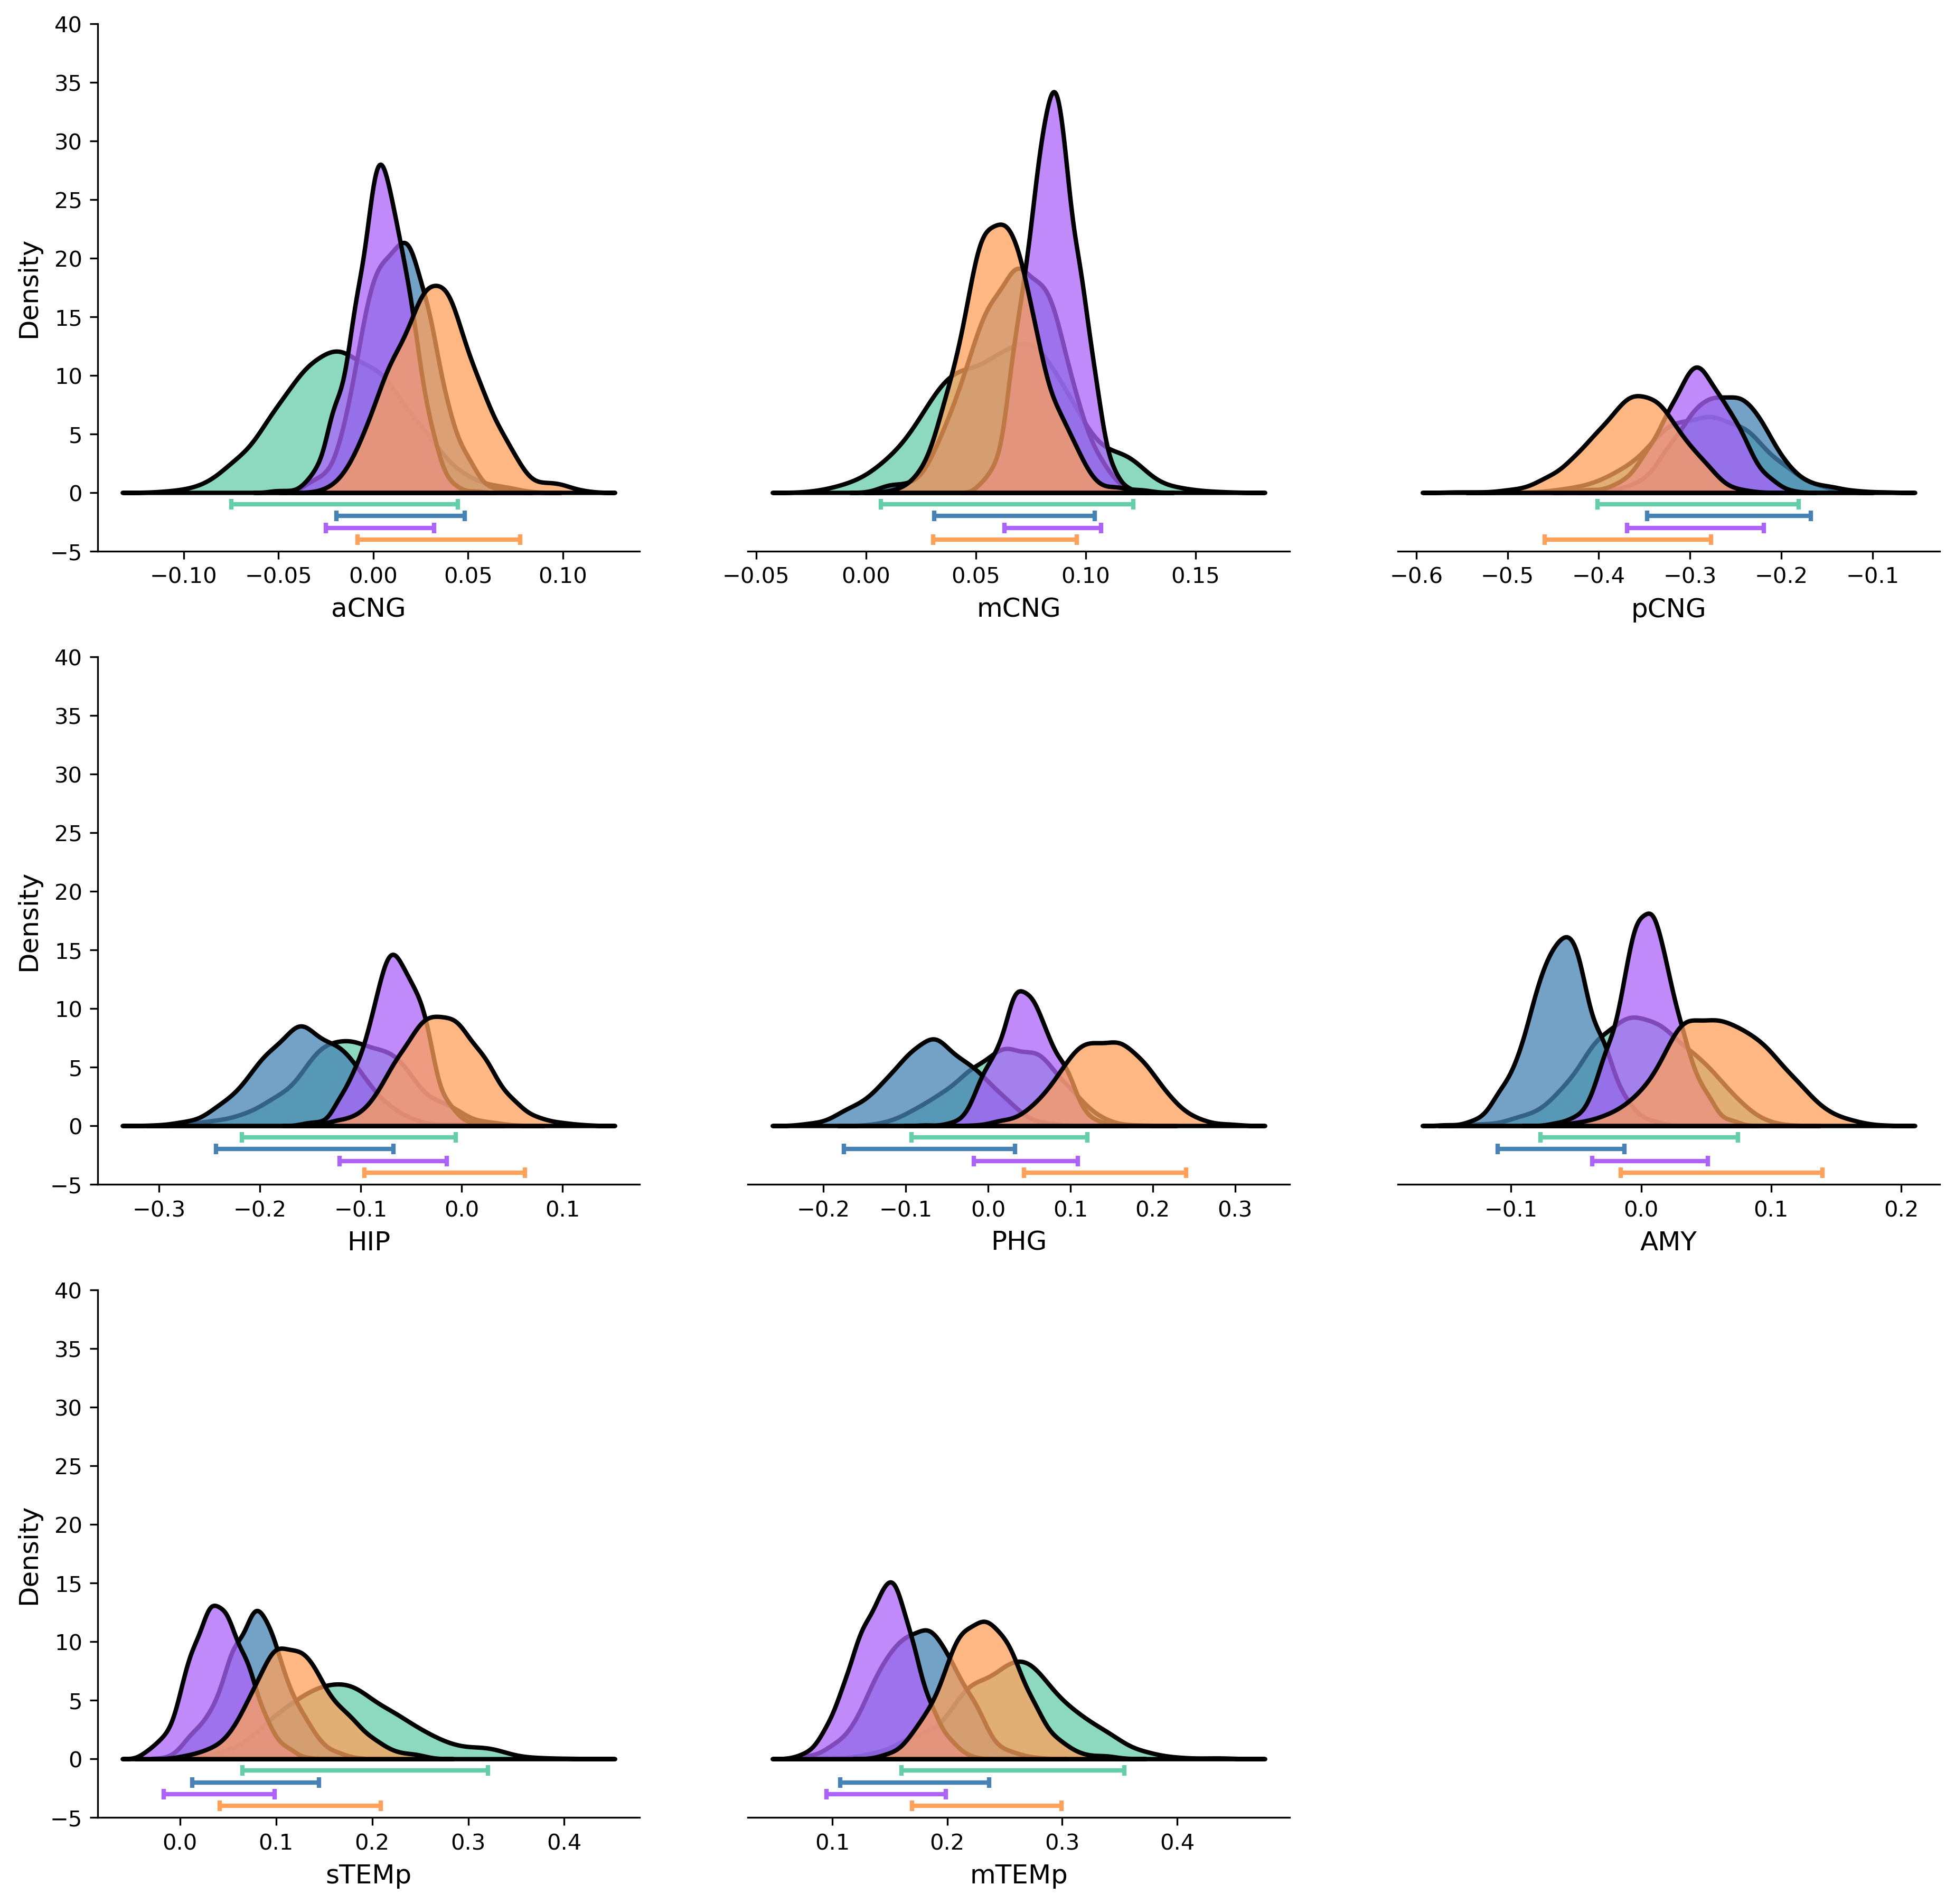

In [17]:
sys.path.append('/home/yat-lok/workspace/tvbtools/')
from tools.statools import bootstrap_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gnames = ["SNC", "NC", "MCI", "AD"]
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
vnames = ["Gamma Frequency", "Theta Frequency", "Gamma Amplitude", "Theta Amplitude", "Phase-Amplitude Coupling", "Phase Locking"]
node_names = ['aCNG', 'mCNG','pCNG', 'HIP','PHG','AMY','sTEMp','mTEMp']



fig = plt.figure(figsize=(15,15), dpi=300)
#df = pd.read_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/gc1sec_res.xlsx')
df = pd.read_excel('/home/yat-lok/workspace/data4project/lateralization/gc1sec_res/weighted_node_degree.xlsx')

for ind, j in enumerate(range(2,18,2)):
    first = (df.iloc[:,j] - min(df.iloc[:,j].min(), df.iloc[:,j+1].min())) / (max(df.iloc[:,j].max(), df.iloc[:,j+1].max()) - min(df.iloc[:,j].min(), df.iloc[:,j+1].min()))
    second = (df.iloc[:,j+1] - min(df.iloc[:,j].min(), df.iloc[:,j+1].min())) / (max(df.iloc[:,j].max(), df.iloc[:,j+1].max()) - min(df.iloc[:,j].min(), df.iloc[:,j+1].min()))

    tmp = second - first
    ddf = pd.DataFrame()
    ddf = pd.concat([ddf, df.group, tmp], axis=1, ignore_index=True)
    ddf.columns = ["group", "value"]
    
    axes = fig.add_subplot(3,3,ind+1)
    axes.set_xlabel(node_names[ind])
    if ind not in [0, 3, 6]:
        axes.spines['left'].set_visible(False)
        axes.get_yaxis().set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    plt.rc('axes', labelsize="large")
    for i in range(4):
        ci, _ = bootstrap_test(ddf["value"][ddf.group == gnames[i]].to_numpy(), iteration=1000, visual=True, axes = axes, color = colors[i])
        axes.set(ylim=(-5, 40))
        axes.hlines(y=-1-i, xmin=ci[0], xmax=ci[1], linewidth=2, color = colors[i])
        axes.vlines(x=ci[0], ymin=-1-i-0.45, ymax=-1-i+0.45, linewidth=2, color = colors[i])
        axes.vlines(x=ci[1], ymin=-1-i-0.45, ymax=-1-i+0.45, linewidth=2, color = colors[i])

        #print(vnames[ind], gnames[i], ci)
        print(node_names[ind], gnames[i], ci)
plt.show()